In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from lmfit import minimize, Parameters, report_fit
import warnings
import matplotlib.pyplot as plt
import scipy.optimize
from intersect import intersection

In [5]:
#Load and prepare data
path_tp = '../../../Data/'
dataTP_05mg = pd.read_csv(path_tp + 'Matthews2017/Digitized/PK/05mg_TP.csv')
dataTP_10mg_ = pd.read_csv(path_tp + 'Matthews2017/Digitized/PK/10mg_TP.csv')
dataTP_10mg_w1 = pd.read_csv(path_tp + 'Grobler2016/Digitized/PK/10mg_TP_W1.csv')
dataTP_10mg_w3 = pd.read_csv(path_tp + 'Grobler2016/Digitized/PK/10mg_TP_W3.csv')
dataTP_30mg_ = pd.read_csv(path_tp + 'Matthews2017/Digitized/PK/30mg_TP.csv')
dataTP_30mg_w1 = pd.read_csv(path_tp + 'Grobler2016/Digitized/PK/30mg_TP_W1.csv')
dataTP_30mg_w3 = pd.read_csv(path_tp + 'Grobler2016/Digitized/PK/30mg_TP_W3.csv')
dataTP_100mg_w1 = pd.read_csv(path_tp + 'Grobler2016/Digitized/PK/100mg_TP_W1.csv')
dataTP_100mg_w3 = pd.read_csv(path_tp + 'Grobler2016/Digitized/PK/100mg_TP_W3.csv')
dataTP_1mg = pd.read_csv(path_tp + 'Matthews2017/Digitized/PK/1mg_TP.csv')
dataTP_2mg = pd.read_csv(path_tp + 'Matthews2017/Digitized/PK/2mg_TP.csv')

dataTP_05mg = dataTP_05mg.dropna(axis='columns')
dataTP_1mg = dataTP_1mg.dropna(axis='columns')
dataTP_2mg = dataTP_2mg.dropna(axis='columns')
dataTP_10mg_ = dataTP_10mg_.dropna(axis='columns')
dataTP_10mg_w1 = dataTP_10mg_w1.dropna(axis='columns')
dataTP_10mg_w3 = dataTP_10mg_w3.dropna(axis='columns')
dataTP_30mg_ = dataTP_30mg_.dropna(axis='columns')
dataTP_30mg_w1 = dataTP_30mg_w1.dropna(axis='columns')
dataTP_30mg_w3 = dataTP_30mg_w3.dropna(axis='columns')
dataTP_100mg_w1 = dataTP_100mg_w1.dropna(axis='columns')
dataTP_100mg_w3 = dataTP_100mg_w3.dropna(axis='columns')

dataTP_05mg.columns = ['time','conc']
dataTP_1mg.columns = ['time','conc']
dataTP_2mg.columns = ['time','conc']
dataTP_10mg_.columns = ['time','conc']
dataTP_10mg_w1.columns = ['time','conc']
dataTP_10mg_w3.columns = ['time','conc']
dataTP_30mg_.columns = ['time','conc']
dataTP_30mg_w1.columns = ['time','conc']
dataTP_30mg_w3.columns = ['time','conc']
dataTP_100mg_w1.columns = ['time','conc']
dataTP_100mg_w3.columns = ['time','conc']

dataTP_10mg = pd.concat([dataTP_10mg_, dataTP_10mg_w1, dataTP_10mg_w3]).sort_values(by=['time']).reset_index(drop=True)
dataTP_30mg = pd.concat([dataTP_30mg_, dataTP_30mg_w1, dataTP_30mg_w3]).sort_values(by=['time']).reset_index(drop=True)
dataTP_100mg = pd.concat([dataTP_100mg_w1, dataTP_100mg_w3]).sort_values(by=['time']).reset_index(drop=True)

dataTP_10mg.time.iloc[0] = abs(dataTP_10mg.time.iloc[0])

datalist_TP = [dataTP_10mg, dataTP_30mg, dataTP_100mg, dataTP_2mg, dataTP_1mg, dataTP_05mg]
data_TP = pd.concat([dataTP_10mg, dataTP_30mg, dataTP_100mg, dataTP_2mg, dataTP_1mg, dataTP_05mg]) #assembled data

#convert to unit nM
data_TP.conc = 6 - np.log10(180) + data_TP.conc.tolist()
for n in range(len(datalist_TP)): #to nM    
    datalist_TP[n].conc = 6 - np.log10(180) + datalist_TP[n].conc.tolist()

t_observed_TP = []; x_observed_TP = []
for d in range(len(datalist_TP)):
    t_observed_TP.append(datalist_TP[d].time.tolist())
    x_observed_TP.append(datalist_TP[d].conc.tolist())
t_observed_TP[0][0] = 0.2

In [6]:
#Compartment model linear PK
def model_TP_linear(t, z, params):
    #parameters to estimate
    ka = params['ka'].value
    k13 = params['k13'].value
    Z0 = z[0]; Z1 = z[1]; Z2 = z[2]; Z3 = z[3]
    dZ0 = -ka*Z0
    dZ1 = (ka/Vc)*Z0 - k10*Z1 - k12*Z1 + k21*Z2
    dZ2 = k12*Z1 - k21*Z2
    dZ3 = k13*Z1 - k30*Z3
    d = [dZ0,dZ1,dZ2,dZ3]
    return d

def solve_ode_TP(z0, params):
    logZ3 = [] #store intracellular concentration
    for j in range(len(z0)):
        t_obs = t_observed_TP[j]
        res = solve_ivp(model_TP_linear, (tstart,tfinal[j]), z0[j], t_eval=t_obs,args=(params,))
        for i in range(len(res.y[3])):
            if res.y[3][i] > 0: logZ3.append(np.log10(res.y[3][i])) #filter negative values
            else: logZ3.append(-10)
    return logZ3

def residual_TP(params, z0, data_mat):
    logZ3 = solve_ode_TP(z0, params)
    return np.power(np.subtract(logZ3,data_TP.conc.tolist()),2)

In [18]:
dose = 3410 #nM
#initial and final time
tstart = 0
tfinal = []
for i in range(len(datalist_TP)):
    tfinal.append(t_observed_TP[i][-1])
#initial satte of the system    
z0 = [[10*dose,0,0,0],[30*dose,0,0,0], [100*dose,0,0,0],[2*dose,0,0,0],[dose,0,0,0],[0.5*dose,0,0,0]] 

#Estimated PK parameters
k10 =  0.2355
k12 =  0.1750
k21 =  0.0259
Vc =  162.6864
k30 = 0.0098

In [30]:
count = 0; maxcount = 10 #initial and maximal number of iterations
RSSList = []
k13List = np.arange(50,35,-(15/100))
kaList= np.arange(30,70,(40/100))

for i in range(len(kaList)):
    #sample ka and k13
    va = kaList[i]
    v13 = k13List[i]
    parameters = Parameters()
    parameters.add('ka', value=va, vary=False)
    parameters.add('k13',value=v13, vary=False)
    #solve ODE for intracellular conc.
    log_Z3 = res = solve_ode_TP(z0, parameters)
    rss = np.sum(np.power(np.subtract(data_TP.conc.tolist(),log_Z3),2))
    RSSList.append(rss)

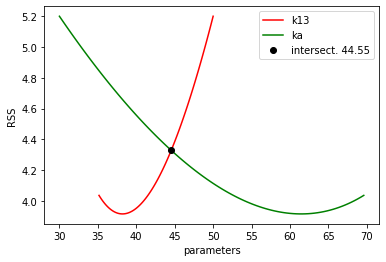

In [63]:
#plot result
x, y = intersection(kaList, RSSList, k13List, RSSList) #calculate intersection between ka and k10 w.r.t. RSS
plt.plot(k13List,RSSList,'r-',label = 'k13')
plt.plot(kaList,RSSList,'g-',label = 'ka')
plt.plot(x[0],y[0],'ko',label='intersect. '+str(round(x[0],2)))
plt.xlabel('parameters')
plt.ylabel('RSS')
plt.legend(loc='best')
#plt.title('ka vs. k13')
plt.show() 